# Metropolis-Hastings Algorithm

### Purpose:
A mechanism to sample from the posterior distribution of a random variable.   
Posterior $\propto$ Prior $\times$ Likelihood  
$P(\theta|x) \propto P(x)P(x|\theta)$

In [19]:
#rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
## for Palatino and other serif fonts use:
import matplotlib as mpl
mpl.rc("savefig", dpi=150)
mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)


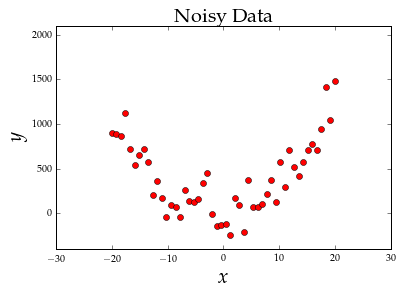

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-20,20,50)
noise = 200*np.random.randn(50,) # sigma = 15
a,b,c = 3,5,0
y = a*x**2+b*x+c+noise
# plot
plt.plot(x,y,'ro')
plt.ylim(ymin=-400,ymax=2100)
plt.xlim(xmin = -30,xmax = 30)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$y$',fontsize=20)

plt.title('Noisy Data',fontsize=20)

171.801420198 [ 2.91531002  5.63464224 -0.21527399]


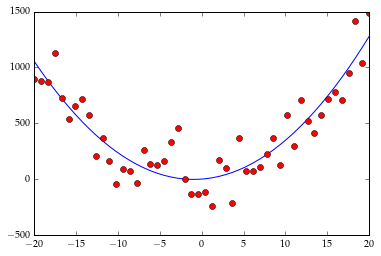

In [21]:
# estimated sigma of y-dist
## Fit a straight line to the data; take sigma of y-pred
pp = np.polyfit(x,y,2)
pred = pp[0]*x**2+pp[1]*x+pp[2]
plt.plot(x,pred,x,y,'ro')#,fillstyle='none')
ysig = np.std(y - pred)
print ysig,pp

In [22]:

import scipy.stats as ss

# Log Likelihood Function
def log_likelihood(params,x,y):
    a=params[0] # quad term
    b=params[1] # linear term
    c=params[2] # constant
    sig = params[3] # using estimated sigma of y
    
    ypred = a*x**2+b*x+c
    yll = ss.norm.logpdf(y,loc=ypred,scale = sig) 
    suml = np.sum(yll)
    return(suml)

# Prior
def log_prior(params):        
    a_pr = ss.uniform.logpdf(params[0],loc=0,scale=10)
    b_pr = ss.norm.logpdf(params[1],loc=0,scale=5)
    c_pr = ss.norm.logpdf(params[2],loc=0,scale=5)
    sig_pr = ss.uniform.logpdf(params[3],loc=50,scale=300)
    #print a_pr,b_pr,c_pr,sig_pr
    lprior = a_pr+b_pr+c_pr+sig_pr
    return(lprior)

# Posterior = Prior X Likelihood/ Normalizing_Constant
def log_posterior(params,x,y):   
    lpost = log_likelihood(params,x,y) + log_prior(params)    
    return(lpost)


(-5327.6734346261519, -263.12608758920959)

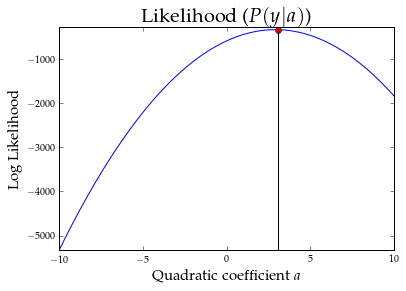

In [23]:
# A sample of what the likelihood function looks like
sample_as = np.linspace(-10,10,50)

y_log_likelihood = [log_likelihood([ax,pp[1],pp[2],170],x,y) for ax in sample_as]
in_mx = np.argmax(y_log_likelihood)
plt.plot(sample_as,y_log_likelihood,sample_as[in_mx],y_log_likelihood[in_mx],'ro')
plt.plot([sample_as[in_mx],sample_as[in_mx]],[1.2*min(y_log_likelihood),y_log_likelihood[in_mx]],'k')
plt.title('Likelihood ($P(y|a)$)',fontsize=20)
plt.xlabel('Quadratic coefficient $a$',fontsize=15)
plt.ylabel('Log Likelihood',fontsize=15)
plt.ylim(ymin=min(y_log_likelihood),ymax = max(y_log_likelihood)*0.8)
#plt.figure(figsize= (30,30))

## Detailed Balance
We assume that the probability distribution of the parameter is stationary.
Now assume that there is a Markov process that allows us to transition from one value $\theta_i$ to $\theta_j$, both of which belong to the stationary distribution $\pi(\theta)$.
Then we have,  
$\pi(\theta_i)P(\theta_j|\theta_i) = \pi(\theta_j)P(\theta_i|\theta_j)$  
This equation is called the **detailed balance equation**. 

However, if we pick some transition probability then we might find that   
$\pi(\theta_i)P(\theta_j|\theta_i) > \pi(\theta_j)P(\theta_i|\theta_j)$  
then we can achieve *Detailed Balance* by adding a term $\alpha$ such that  
$\pi(\theta_i)P(\theta_j|\theta_i) \times \alpha =  \pi(\theta_j)P(\theta_i|\theta_j)$   

$\alpha =  \frac{\pi(\theta_j)P(\theta_i|\theta_j)}{\pi(\theta_i)P(\theta_j|\theta_i)}$  

If $\alpha>1$ then we surely transition to $\theta_j$ else we stay at $\theta_i$ with probability $\alpha$. Here $P$ is called *proposal distribution*.


In [67]:
# The Metropolis Hastings Algorithm
# We shall sample from the posterior to get robust estimate 
# of the parameters

def proposal(params):
    rv1 = ss.norm.rvs(loc = params[0] ,scale = 0.1)
    rv2 = ss.norm.rvs(loc = params[1], scale = 0.7)
    rv3 = ss.norm.rvs(loc = params[2], scale = 1)
    rv4 = ss.norm.rvs(loc= params[3],scale=7)
    #print rv1,rv2,rv3,rv4
    return([rv1,rv2,rv3,rv4])


# init_val initial guess
# N = Number of iterations
def metro_hastings(init_val,N,x,y):    
    mc = np.empty([N,4]) # markov chain
    mc[0,:]= init_val
    ac = np.empty([N-1])
    pc = np.empty([N-1])
    
    for i in range(N-1):
        prps = proposal(mc[i,:]) # proposed random sample
        #if log_prior(prps)==-float("inf"):
        #    print log_prior(prps),prps
        alpha = np.exp(log_posterior(prps,x,y) - log_posterior(mc[i,:],x,y))
        
        #if i%500==0:
        #    print alpha,prps,log_posterior(prps,x,y)
        if alpha > ss.uniform.rvs():
            mc[i+1,:] = prps
            ac[i] = alpha
            pc[i] = log_posterior(prps,x,y) - log_posterior(mc[i,:],x,y)
        else:
            mc[i+1,:] = mc[i,:]
            ac[i]= ac[i-1]   
            pc[i]=0
    return(mc,ac,pc) 



In [68]:
init_value = [10,20,10,170]
mc,ac,pc=metro_hastings(init_value,20000,x,y)

In [69]:
# Estimate of alpha (acceptance ratio)
transient=10000
est_alpha = float(len(np.unique(mc[transient:,1])))/len(mc[transient:,1])
print est_alpha*100,'%'

68.07 %


The Estimated Parameters Means are: 
[  2.91409251e+00   4.56300111e+00  -7.00112796e-02   1.78974264e+02]


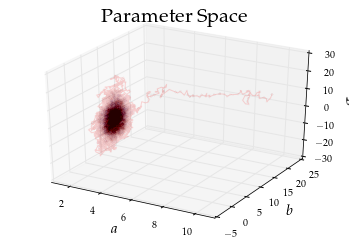

In [70]:
#%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(mc[:20000,0],mc[:20000,1],mc[:20000,2],c='r',alpha=0.15)
#ax.plot(mc[15001:20000,0],mc[15001:20000,1],mc[15001:20000,2],c='b',alpha=0.1)
ax.scatter(mc[:15000,0],mc[:15000,1],mc[:15000,2],marker='.',c='r',alpha=0.005)
ax.scatter(mc[15001:20000,0],mc[15001:20000,1],mc[15001:20000,2],marker='.',c='b',alpha=0.005)
mest = np.mean(mc[15001:,:],0)
ax.scatter(mest[0],mest[1],mest[2],c='g',marker='o')
ax.set_xlabel('$a$',fontsize=15)
ax.set_ylabel('$b$',fontsize=15)
ax.set_zlabel('$\sigma$',fontsize=15)
ax.set_title('Parameter Space',fontsize=20)
print 'The Estimated Parameters Means are: \n',np.mean(mc[-5000:,:],0)


In [71]:
np.mean(mc[15000:,2])

-0.07001127958839734

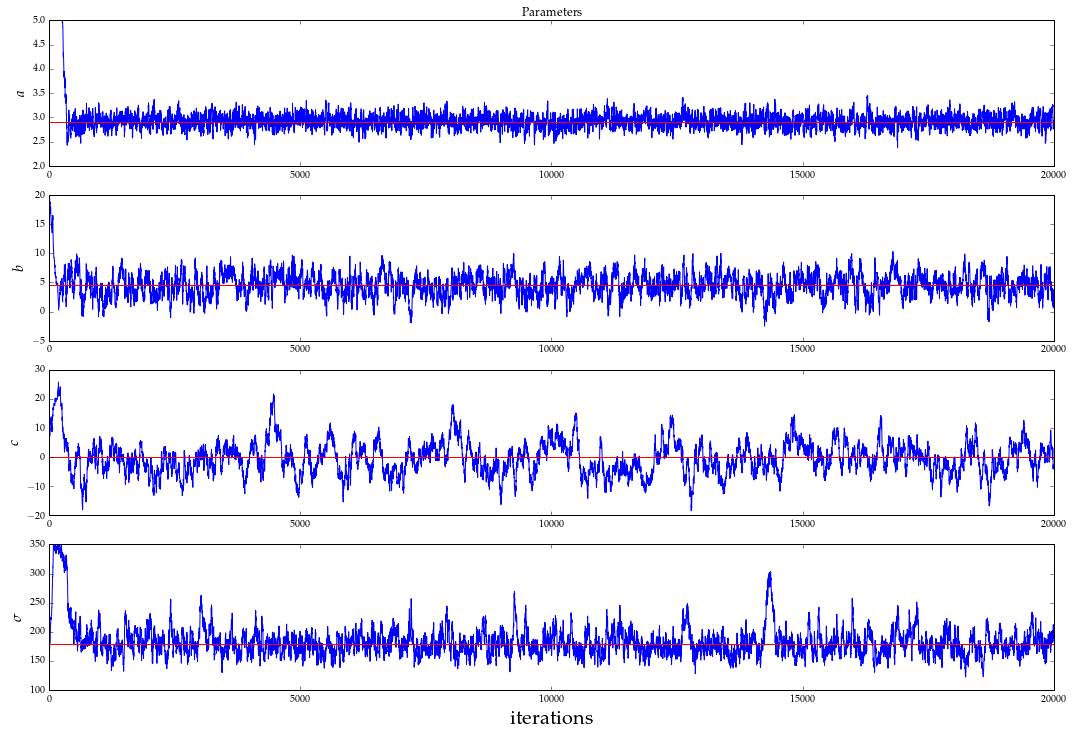

In [72]:
%matplotlib inline
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(18)

fig.add_subplot(4,1,1)
plt.plot(range(20000),mc[:20000,0])
plt.plot([0,20000],[mest[0],mest[0]],'r')
plt.ylabel('$a$',fontsize=15)
plt.ylim(ymax=5)
plt.title('Parameters')

fig.add_subplot(412)
plt.plot(range(20000),mc[:20000,1])
plt.plot([0,20000],[mest[1],mest[1]],'r')
plt.ylabel('$b$',fontsize=15)

fig.add_subplot(413)
plt.plot(range(20000),mc[:20000,2])
plt.plot([0,20000],[mest[2],mest[2]],'r')
plt.ylabel('$c$',fontsize=15)

fig.add_subplot(414)
plt.plot(range(20000),mc[:20000,3])
plt.plot([0,20000],[mest[3],mest[3]],'r')
plt.ylabel('$\sigma$',fontsize=15)
plt.xlabel('iterations',fontsize=20)

Red Lines show means: [  2.91409637e+00   4.56261344e+00  -7.09149622e-02   1.78976597e+02]


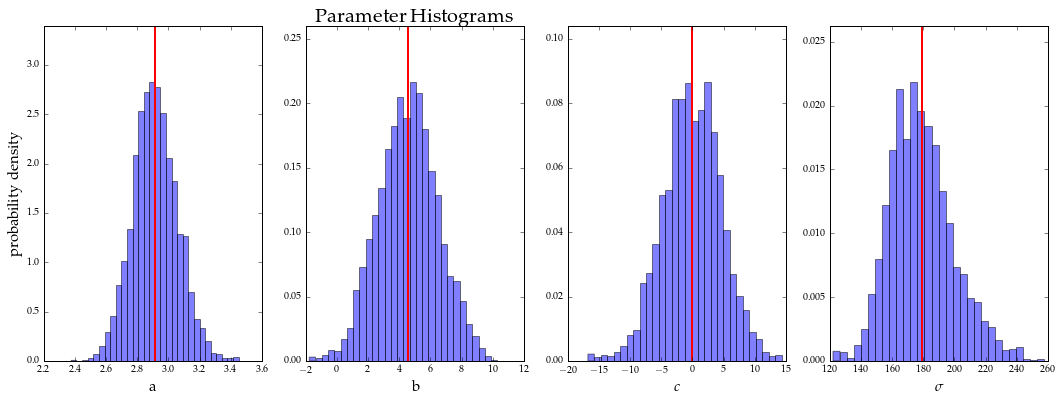

In [73]:
#%matplotlib notebook
#%matplotlib notebook

fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(18)

fig.add_subplot(1,4,1)
n, bins, patches = plt.hist(mc[15000:,0], 30, normed=1, facecolor='b', alpha=0.5)
plt.plot([mest[0],mest[0]],[0,max(n)*1.2],'r',linewidth=2)
plt.xlabel('a',fontsize=15)
plt.ylabel('probability density',fontsize=15)
plt.ylim(ymax=max(n)*1.2)

fig.add_subplot(1,4,2)
n, bins, patches = plt.hist(mc[15000:,1], 30, normed=1, facecolor='b', alpha=0.5)
plt.plot([mest[1],mest[1]],[0,max(n)*1.2],'r',linewidth=2)
plt.xlabel('b',fontsize=15)
plt.ylim(ymax=max(n)*1.2)
plt.title('$\:\:\:$ Parameter Histograms',fontsize=20)

fig.add_subplot(1,4,3)
n, bins, patches = plt.hist(mc[15000:,2], 30, normed=1, facecolor='b', alpha=0.5)
plt.plot([mest[2],mest[2]],[0,max(n)*1.2],'r',linewidth=2)
plt.xlabel('$c$',fontsize=15)
plt.ylim(ymax=max(n)*1.2)

fig.add_subplot(1,4,4)
n, bins, patches = plt.hist(mc[15000:,3], 30, normed=1, facecolor='b', alpha=0.5)
plt.plot([mest[3],mest[3]],[0,max(n)*1.2],'r',linewidth=2)
plt.xlabel('$\sigma$',fontsize=15)
plt.ylim(ymax=max(n)*1.2)

print 'Red Lines show means:', mest